# Initialize notebook

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import seaborn as sn
import statistics
from tqdm import tqdm
import time
from functools import partial
from operator import is_not
import pickle

import sklearn as skl
from sklearn.linear_model import LinearRegression
import sklearn.pipeline as skl_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from scipy.optimize import curve_fit

In [2]:
# Constants
#KITTI_DATASET = '/media/javier/HDD_linux/KITTI_dataset/training/'
KITTI_DATASET = '/media/robesafe/SSD_SATA/KITTI_DATASET/'

# Load dataframe

In [3]:
df_train = pd.read_csv (KITTI_DATASET+'kitti_train_gt.csv')
df_val = pd.read_csv (KITTI_DATASET+'kitti_val_gt.csv')

In [4]:
df_train

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,...,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom
0,0,0,Pedestrian,0.00,0.0,-0.20,712.40,143.00,810.73,307.92,...,1.84,1.47,8.41,0.01,8.733533,164.92,98.33,0.21,False,False
1,1,0,Car,0.00,0.0,1.85,387.63,181.54,423.81,203.12,...,-16.53,2.39,58.49,1.57,60.827897,21.58,36.18,-0.28,False,False
2,1,1,Cyclist,0.00,3.0,-1.65,676.60,163.95,688.98,193.93,...,4.59,1.32,45.84,-1.55,46.088134,29.98,12.38,0.10,False,False
3,2,0,Car,0.00,0.0,-1.67,657.39,190.13,700.07,223.39,...,3.18,2.27,34.38,-1.58,34.601296,33.26,42.68,0.09,False,False
4,3,0,Car,0.00,0.0,1.55,614.24,181.78,727.31,284.77,...,1.00,1.75,13.22,1.62,13.372767,102.99,113.07,0.07,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27993,5983,8,Car,0.00,2.0,-1.72,668.22,167.79,726.04,215.88,...,2.95,1.42,25.30,-1.61,25.510956,48.09,57.82,0.11,False,False
27994,5983,9,Car,0.00,1.0,-1.66,640.25,174.03,671.68,198.24,...,2.70,1.47,43.39,-1.60,43.498770,24.21,31.43,0.06,False,False
27995,5983,10,Car,0.77,3.0,2.27,0.00,196.98,95.57,298.45,...,-9.21,1.73,10.06,1.55,13.748476,101.47,95.57,-0.72,True,False
27996,5983,11,Car,0.00,2.0,-1.57,594.88,172.76,633.46,207.96,...,0.16,1.54,33.23,-1.56,33.266050,35.20,38.58,0.01,False,False


# Distance regression method

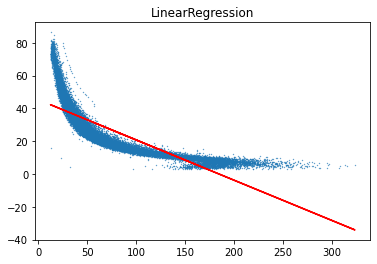

In [5]:
Y = df_train['distance'].values.reshape(-1, 1)
X = df_train['height_image'].values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y, s=0.1)
plt.plot(X, Y_pred, color='red')
plt.title('LinearRegression')

plt.show()

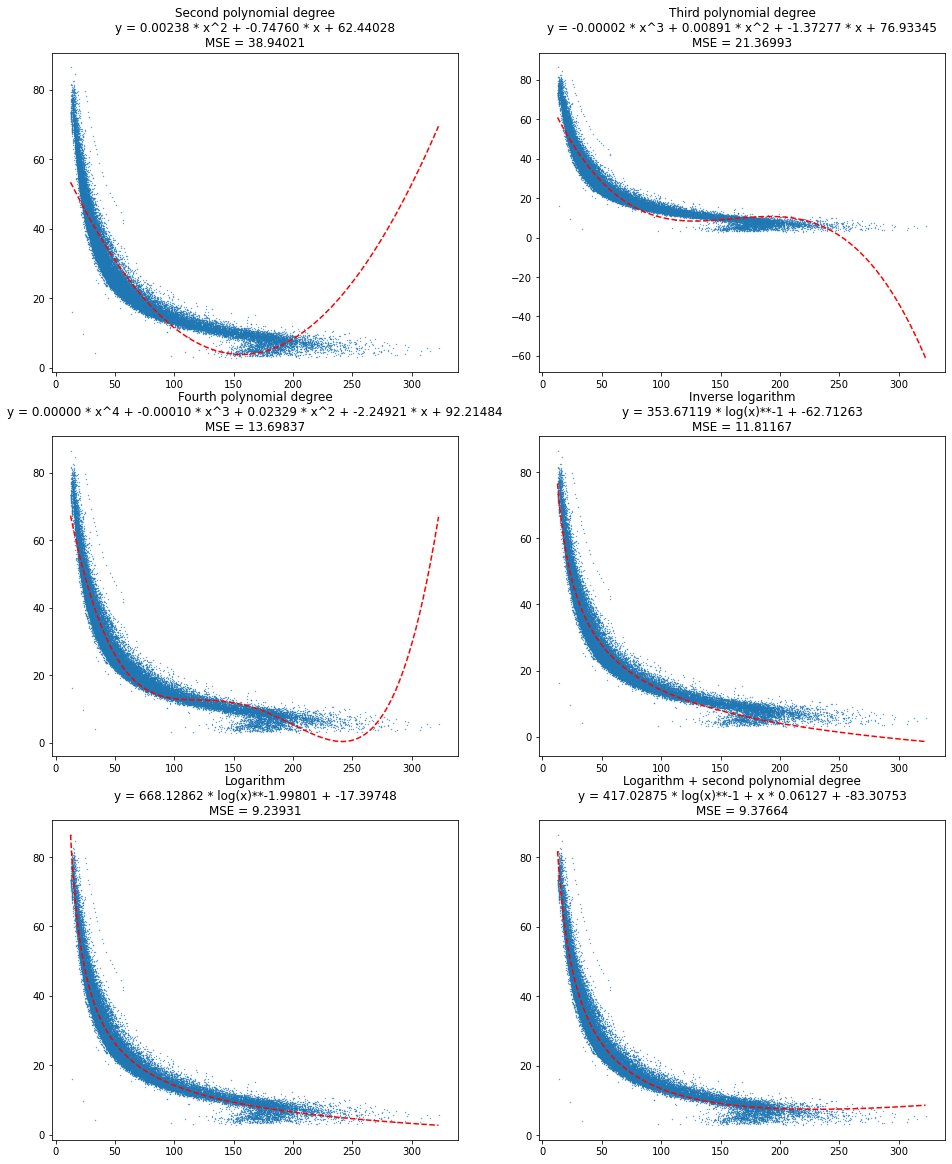

In [6]:
plt.figure(figsize=(16, 20))

Y = df_train['distance'].values
X = df_train['height_image'].values

Y_val = df_val['distance'].values
X_val = df_val['height_image'].values

def objective_2f(x, a, b, c):
    return a * x**2 + b * x + c

def objective_3f(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def objective_4f(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

def objective_log_1f(x, a, b):
    return a * np.log(x)**-1 + b 

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c 

def objective_log_1_f(x, a, b, c):
    return a * np.log(x)**-1 + b * x + c 

plt.subplot(3, 2, 1)
popt, _ = curve_fit(objective_2f, X, Y, maxfev = 1000)
a, b, c = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_2f(X_line, a, b, c)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_2f(X_val, a, b, c)
mse = mean_squared_error(Y_val, Y_pred)
plt.title('Second polynomial degree\ny = %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f' % (a, b, c, mse))

plt.subplot(3, 2, 2)
popt, _ = curve_fit(objective_3f, X, Y, maxfev = 1000)
a, b, c, d = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_3f(X_line, a, b, c, d)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_3f(X_val, a, b, c, d)
mse = mean_squared_error(Y_val, Y_pred)
plt.title('Third polynomial degree\ny = %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f' % (a, b, c, d, mse))

plt.subplot(3, 2, 3)
popt, _ = curve_fit(objective_4f, X, Y, maxfev = 1000)
a, b, c, d, e = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_4f(X_line, a, b, c, d, e)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_4f(X_val, a, b, c, d, e)
mse = mean_squared_error(Y_val, Y_pred)
plt.title('Fourth polynomial degree\ny = %.5f * x^4 + %.5f * x^3 + %.5f * x^2 + %.5f * x + %.5f\nMSE = %.5f' % (a, b, c, d, e, mse))

plt.subplot(3, 2, 4)
popt, _ = curve_fit(objective_log_1f, X, Y, maxfev = 1000)
a, b = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_log_1f(X_line, a, b)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_log_1f(X_val, a, b)
mse = mean_squared_error(Y_val, Y_pred)
plt.title('Inverse logarithm\ny = %.5f * log(x)**-1 + %.5f\nMSE = %.5f' % (a, b, mse))

plt.subplot(3, 2, 5)
popt, _ = curve_fit(objective_log_f, X, Y, maxfev = 10000)
a, b, c = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_log_f(X_line, a, b, c)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_log_f(X_val, a, b, c)
mse = mean_squared_error(Y_val, Y_pred)
plt.title('Logarithm\ny = %.5f * log(x)**%.5f + %.5f\nMSE = %.5f' % (a, b, c, mse))

plt.subplot(3, 2, 6)
popt, _ = curve_fit(objective_log_1_f, X, Y, maxfev = 10000)
a, b, c = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_log_1_f(X_line, a, b, c)
plt.plot(X_line, Y_line, '--', color='red')
Y_pred = objective_log_1_f(X_val, a, b, c)
mse = mean_squared_error(Y_val, Y_pred)
plt.title('Logarithm + second polynomial degree\ny = %.5f * log(x)**-1 + x * %.5f + %.5f\nMSE = %.5f' % (a, b, c, mse))

plt.show()

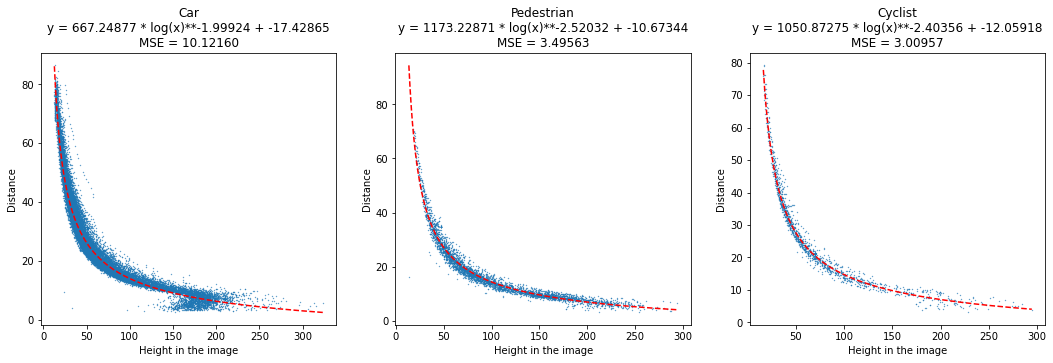

In [7]:
plt.figure(figsize=(18, 5))

df_car = df_train[df_train['type'] == 'Car']
df_pedestrian = df_train[df_train['type'] == 'Pedestrian']
df_cyclist = df_train[df_train['type'] == 'Cyclist']

df_car_val = df_val[df_val['type'] == 'Car']
df_pedestrian_val = df_val[df_val['type'] == 'Pedestrian']
df_cyclist_val = df_val[df_val['type'] == 'Cyclist']

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c 

dfs = [df_car, df_pedestrian, df_cyclist]
dfs_val = [df_car_val, df_pedestrian_val, df_cyclist_val]
titles = ['Car', 'Pedestrian', 'Cyclist']

models = []

popt_pedestrian = None
popt_cyclist = None

for i in range(3):
    plt.subplot(1, 3, i+1)
    X = dfs[i]['height_image']
    Y = dfs[i]['distance']
    
    X_val = dfs_val[i]['height_image']
    Y_val = dfs_val[i]['distance']
    
    popt, _ = curve_fit(objective_log_f, X, Y, maxfev = 1000000)
    
    if i==1:
        popt_pedestrian = popt
    elif i==2:
        popt_cyclist = popt
    
    # Save models
    models.append((popt,objective_log_f))
    
    a, b, c = popt
    plt.scatter(X, Y, s=0.1)
    X_line = np.arange(min(X), max(X), 0.1)
    Y_line = objective_log_f(X_line, a, b, c)
    plt.plot(X_line, Y_line, '--', color='red')
    plt.ylabel('Distance')
    plt.xlabel('Height in the image')
    Y_pred = objective_log_f(X_val, a, b, c)
    mse = mean_squared_error(Y_val, Y_pred)
    plt.title(titles[i]+str('\ny = %.5f * log(x)**%.5f + %.5f\nMSE = %.5f' % (a, b, c, mse)))

plt.show()

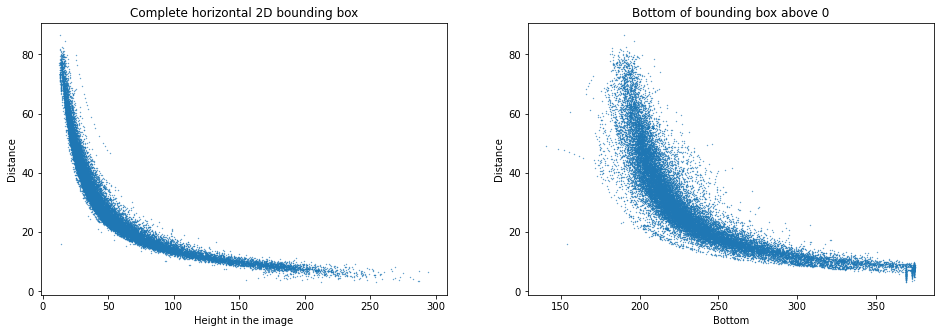

*Incomplete horizontal 2D bounding box*
count     27998
unique        2
top       False
freq      24989
Name: incomplete_2d_horizontal, dtype: object

*Bottom of bounding box above 0*
count     27998
unique        1
top       False
freq      27998
Name: incomplete_2d_bottom, dtype: object



In [8]:
plt.figure(figsize=(16, 5))

df_complete_2d_horizontal = df_train[df_train['incomplete_2d_horizontal'] == False]
df_complete_2d_bottom = df_train[df_train['incomplete_2d_bottom'] == False]

plt.subplot(1, 2, 1)
Y = df_complete_2d_horizontal['distance'].values
X = df_complete_2d_horizontal['height_image'].values
plt.scatter(X, Y, s=0.1)
plt.title('Complete horizontal 2D bounding box')
plt.xlabel('Height in the image')
plt.ylabel('Distance')

plt.subplot(1, 2, 2)
Y = df_complete_2d_horizontal['distance'].values
X = df_complete_2d_horizontal['bottom'].values
plt.scatter(X, Y, s=0.1)
plt.title('Bottom of bounding box above 0')
plt.xlabel('Bottom')
plt.ylabel('Distance')

plt.show()

print('*Incomplete horizontal 2D bounding box*')
print(df_train['incomplete_2d_horizontal'].describe())
print()
print('*Bottom of bounding box above 0*')
print(df_train['incomplete_2d_bottom'].describe())
print()

## Study taking into account the completeness of the bounding box

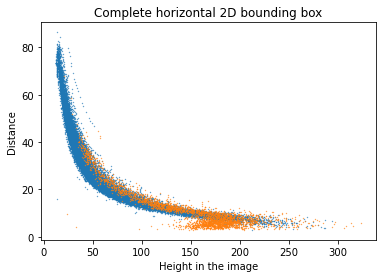

In [102]:
df_incomplete_2d_horizontal = df_train[df_train['incomplete_2d_horizontal'] == True]
df_complete_2d_horizontal = df_train[df_train['incomplete_2d_horizontal'] == False]

Y = df_complete_2d_horizontal['distance'].values
X = df_complete_2d_horizontal['height_image'].values
plt.scatter(X, Y, s=0.1)
Y = df_incomplete_2d_horizontal['distance'].values
X = df_incomplete_2d_horizontal['height_image'].values
plt.scatter(X, Y, s=0.1)
plt.title('Complete horizontal 2D bounding box')
plt.xlabel('Height in the image')
plt.ylabel('Distance')

plt.show()

In [10]:
df_car_complete_train = df_train[(df_train['type'] == 'Car') & (df_train['incomplete_2d_horizontal'] == False)]
df_pedestrian_complete_train = df_train[(df_train['type'] == 'Pedestrian') & (df_train['incomplete_2d_horizontal'] == False)]
df_cyclist_complete_train = df_train[(df_train['type'] == 'Cyclist') & (df_train['incomplete_2d_horizontal'] == False)]

print("len(df_car_complete_train)=%s"%len(df_car_complete_train))
print("len(df_pedestrian_complete_train)=%s"%len(df_pedestrian_complete_train))
print("len(df_cyclist_complete_train)=%s"%len(df_cyclist_complete_train), end="\n\n")

df_car_complete_val = df_val[(df_val['type'] == 'Car') & (df_val['incomplete_2d_horizontal'] == False)]
df_pedestrian_complete_val = df_val[(df_val['type'] == 'Pedestrian') & (df_val['incomplete_2d_horizontal'] == False)]
df_cyclist_complete_val = df_val[(df_val['type'] == 'Cyclist') & (df_val['incomplete_2d_horizontal'] == False)]

print("len(df_car_complete_val)=%s"%len(df_car_complete_val))
print("len(df_pedestrian_complete_val)=%s"%len(df_pedestrian_complete_val))
print("len(df_cyclist_complete_val)=%s"%len(df_cyclist_complete_val), end="\n\n")

df_car_incomplete_train = df_train[(df_train['type'] == 'Car') & (df_train['incomplete_2d_horizontal'] == True)]
df_pedestrian_incomplete_train = df_train[(df_train['type'] == 'Pedestrian') & (df_train['incomplete_2d_horizontal'] == True)]
df_cyclist_incomplete_train = df_train[(df_train['type'] == 'Cyclist') & (df_train['incomplete_2d_horizontal'] == True)]

print("len(df_car_incomplete_train)=%s"%len(df_car_incomplete_train))
print("len(df_pedestrian_incomplete_train)=%s"%len(df_pedestrian_incomplete_train))
print("len(df_cyclist_incomplete_train)=%s"%len(df_cyclist_incomplete_train), end="\n\n")

df_car_incomplete_val = df_val[(df_val['type'] == 'Car') & (df_val['incomplete_2d_horizontal'] == True)]
df_pedestrian_incomplete_val = df_val[(df_val['type'] == 'Pedestrian') & (df_val['incomplete_2d_horizontal'] == True)]
df_cyclist_incomplete_val = df_val[(df_val['type'] == 'Cyclist') & (df_val['incomplete_2d_horizontal'] == True)]

print("len(df_car_incomplete_val)=%s"%len(df_car_incomplete_val))
print("len(df_pedestrian_incomplete_val)=%s"%len(df_pedestrian_incomplete_val))
print("len(df_cyclist_incomplete_val)=%s"%len(df_cyclist_incomplete_val), end="\n\n")

len(df_car_complete_train)=20171
len(df_pedestrian_complete_train)=3555
len(df_cyclist_complete_train)=1263

len(df_car_complete_val)=2496
len(df_pedestrian_complete_val)=465
len(df_cyclist_complete_val)=143

len(df_car_incomplete_train)=2878
len(df_pedestrian_incomplete_train)=59
len(df_cyclist_incomplete_train)=72

len(df_car_incomplete_val)=352
len(df_pedestrian_incomplete_val)=8
len(df_cyclist_incomplete_val)=7



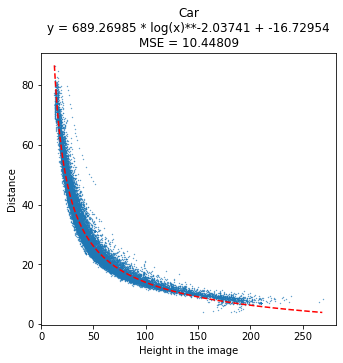

In [11]:
# Fit to complete bb 2D

plt.figure(figsize=(18, 5))

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c 

plt.subplot(1, 3, i+1)
X = df_car_complete_train['height_image']
Y = df_car_complete_train['distance']

X_val = df_car_complete_val['height_image']
Y_val = df_car_complete_val['distance']

popt, _ = curve_fit(objective_log_f, X, Y, maxfev = 1000000)
popt_car_complete = popt
a, b, c = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_log_f(X_line, a, b, c)
plt.plot(X_line, Y_line, '--', color='red')
plt.ylabel('Distance')
plt.xlabel('Height in the image')
Y_pred = objective_log_f(X_val, a, b, c)
mse = mean_squared_error(Y_val, Y_pred)
plt.title(str('Car\ny = %.5f * log(x)**%.5f + %.5f\nMSE = %.5f' % (a, b, c, mse)))

plt.show()

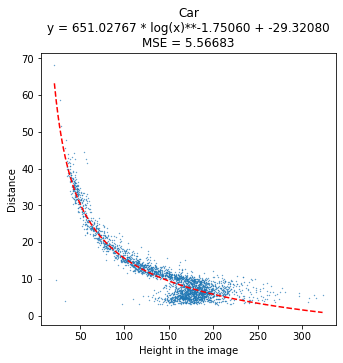

In [12]:
# Fit to incomplete bb 2D

plt.figure(figsize=(18, 5))

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c 

plt.subplot(1, 3, i+1)
X = df_car_incomplete_train['height_image']
Y = df_car_incomplete_train['distance']

X_val = df_car_incomplete_val['height_image']
Y_val = df_car_incomplete_val['distance']

popt, _ = curve_fit(objective_log_f, X, Y, maxfev = 1000000)
popt_car_incomplete = popt
a, b, c = popt
plt.scatter(X, Y, s=0.1)
X_line = np.arange(min(X), max(X), 1)
Y_line = objective_log_f(X_line, a, b, c)
plt.plot(X_line, Y_line, '--', color='red')
plt.ylabel('Distance')
plt.xlabel('Height in the image')
Y_pred = objective_log_f(X_val, a, b, c)
mse = mean_squared_error(Y_val, Y_pred)
plt.title(str('Car\ny = %.5f * log(x)**%.5f + %.5f\nMSE = %.5f' % (a, b, c, mse)))

plt.show()

In [13]:
df_car_val

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,...,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom
0,5984,0,Car,0.00,1.0,3.10,431.50,171.26,514.83,204.10,...,-6.60,1.44,34.58,2.91,35.233649,32.84,83.33,-0.19,False,False
2,5984,2,Car,0.00,0.0,1.22,699.42,157.64,744.58,190.94,...,7.73,1.22,50.24,1.37,50.845835,33.30,45.16,0.15,False,False
3,5984,3,Car,0.00,1.0,-2.01,729.47,164.21,774.61,189.74,...,10.11,1.18,51.72,-1.82,52.712075,25.53,45.14,0.19,False,False
4,5984,4,Car,0.00,0.0,-2.05,767.91,164.74,823.24,187.41,...,13.25,1.02,51.91,-1.80,53.584055,22.67,55.33,0.25,False,False
5,5984,5,Car,0.00,2.0,-2.18,939.91,161.75,987.23,183.39,...,25.99,0.76,53.17,-1.73,59.187048,21.64,47.32,0.45,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3466,6731,3,Car,0.00,1.0,-1.76,285.26,204.19,379.79,277.17,...,-7.46,2.49,19.09,-2.13,20.646545,72.98,94.53,-0.37,False,False
3467,6731,4,Car,0.00,1.0,1.68,19.76,205.74,103.40,276.05,...,-17.25,2.97,22.81,1.04,28.752035,70.31,83.64,-0.64,False,False
3468,6731,5,Car,0.64,3.0,1.68,0.00,223.85,52.39,320.28,...,-11.47,2.50,13.38,0.99,17.799868,96.43,52.39,-0.69,True,False
3469,6731,6,Car,0.00,2.0,-1.70,235.01,212.29,293.06,253.39,...,-14.27,3.08,29.56,-2.14,32.968362,41.10,58.05,-0.44,False,False


In [14]:
df_car_val['incomplete_2d_horizontal']

0       False
2       False
3       False
4       False
5       False
        ...  
3466    False
3467    False
3468     True
3469    False
3470    False
Name: incomplete_2d_horizontal, Length: 2848, dtype: bool

In [15]:
def apply_distance_method_type(top, bottom, weigths, function):
    height = bottom - top
    return function(height,*weigths)

In [16]:
df_car_complete_val

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,...,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom
0,5984,0,Car,0.0,1.0,3.10,431.50,171.26,514.83,204.10,...,-6.60,1.44,34.58,2.91,35.233649,32.84,83.33,-0.19,False,False
2,5984,2,Car,0.0,0.0,1.22,699.42,157.64,744.58,190.94,...,7.73,1.22,50.24,1.37,50.845835,33.30,45.16,0.15,False,False
3,5984,3,Car,0.0,1.0,-2.01,729.47,164.21,774.61,189.74,...,10.11,1.18,51.72,-1.82,52.712075,25.53,45.14,0.19,False,False
4,5984,4,Car,0.0,0.0,-2.05,767.91,164.74,823.24,187.41,...,13.25,1.02,51.91,-1.80,53.584055,22.67,55.33,0.25,False,False
5,5984,5,Car,0.0,2.0,-2.18,939.91,161.75,987.23,183.39,...,25.99,0.76,53.17,-1.73,59.187048,21.64,47.32,0.45,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,6731,2,Car,0.0,1.0,-1.85,341.69,208.45,475.95,298.84,...,-4.21,2.20,14.50,-2.13,15.258247,90.39,134.26,-0.28,False,False
3466,6731,3,Car,0.0,1.0,-1.76,285.26,204.19,379.79,277.17,...,-7.46,2.49,19.09,-2.13,20.646545,72.98,94.53,-0.37,False,False
3467,6731,4,Car,0.0,1.0,1.68,19.76,205.74,103.40,276.05,...,-17.25,2.97,22.81,1.04,28.752035,70.31,83.64,-0.64,False,False
3469,6731,6,Car,0.0,2.0,-1.70,235.01,212.29,293.06,253.39,...,-14.27,3.08,29.56,-2.14,32.968362,41.10,58.05,-0.44,False,False


/home/robesafe/anaconda3/envs/javi_tfm/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/robesafe/anaconda3/envs/javi_tfm/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


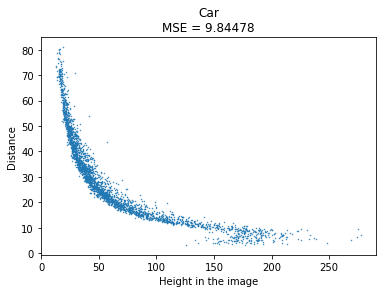

In [17]:
# Evaluate taking into account the completeness of the bounding box

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c 

df_car_complete_val['distance_approx'] = apply_distance_method_type(df_car_complete_val['top'],
                                                                    df_car_complete_val['bottom'],
                                                                    popt_car_complete,
                                                                    objective_log_f)
df_car_incomplete_val['distance_approx'] = apply_distance_method_type(df_car_incomplete_val['top'],
                                                                      df_car_incomplete_val['bottom'],
                                                                      popt_car_incomplete,
                                                                      objective_log_f)
df_car_val = pd.concat([df_car_complete_val, df_car_incomplete_val])

X_val = df_car_val['height_image']
Y_val = df_car_val['distance']

plt.scatter(X_val, Y_val, s=0.2)
plt.ylabel('Distance')
plt.xlabel('Height in the image')
mse = mean_squared_error(Y_val, df_car_val['distance_approx'])
plt.title(str('Car\nMSE = %.5f' % (mse)))

plt.show()

### Save regression model

In [86]:
def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c

class Regression_model:
    def __init__(self, function, variables):
        self.function = function
        self.variables = variables
    def __str__(self):
        return "function = %s, variables = %s"%(self.function, self.variables)

class Regression_model_class:
    def __init__(self, model_car, model_pedestrian, model_cyclist):
        self.car = model_car
        self.pedestrian = model_pedestrian
        self.cyclist = model_cyclist
    def __str__(self):
        return "car: {%s} \npedestrian: {%s} \ncyclist: {%s}\n"%(self.car, self.pedestrian, self.cyclist)
        
class Regression_model_bb:
    def __init__(self, bb_complete, bb_incomplete):
        self.bb_complete = bb_complete
        self.bb_incomplete = bb_incomplete
    def __str__(self):
        return "bb_complete: {%s},\nbb_incomplete: {%s}\n"%(self.bb_complete, self.bb_incomplete)

In [87]:
height_model = Regression_model_class(Regression_model_bb(Regression_model(objective_log_f, popt_car_complete),
                                                          Regression_model(objective_log_f, popt_car_incomplete)),
                                      Regression_model(objective_log_f, popt_pedestrian),
                                      Regression_model(objective_log_f, popt_cyclist))

In [81]:
print(height_model)

car: {bb_complete: {function = <function objective_log_f at 0x7fb563dd7488>, variables = [689.26985181  -2.0374056  -16.72954044]},
bb_incomplete: {function = <function objective_log_f at 0x7fb563dd7488>, variables = [651.02767472  -1.7506046  -29.32080446]}
} 
pedestrian: {function = <function objective_log_f at 0x7fb563dd7488>, variables = [1173.22871064   -2.52031575  -10.67344022]} 
cyclist: {function = <function objective_log_f at 0x7fb563dd7488>, variables = [1050.87275107   -2.40355944  -12.05918045]}



In [84]:
with open('height_model.pkl', 'wb') as f:
    f.write(pickle.dumps(height_model))

In [85]:
with open('height_model.pkl', 'rb') as f:
    height_model_read = pickle.load(f)
    print(height_model_read)

car: {bb_complete: {function = <function objective_log_f at 0x7fb563dd7488>, variables = [689.26985181  -2.0374056  -16.72954044]},
bb_incomplete: {function = <function objective_log_f at 0x7fb563dd7488>, variables = [651.02767472  -1.7506046  -29.32080446]}
} 
pedestrian: {function = <function objective_log_f at 0x7fb563dd7488>, variables = [1173.22871064   -2.52031575  -10.67344022]} 
cyclist: {function = <function objective_log_f at 0x7fb563dd7488>, variables = [1050.87275107   -2.40355944  -12.05918045]}



### Approximate distances

In [93]:
def approximate_distance(type_name, top, bottom, bb_complete, model):
    height = bottom - top
    if type_name == 'Car':
        if bb_complete:
            f = model.car.bb_complete.function
            return f(height, *model.car.bb_complete.variables)
        else:
            f = model.car.bb_incomplete.function
            return f(height, *model.car.bb_incomplete.variables)
    elif type_name == 'Pedestrian':
        f = model.pedestrian.function
        return f(height, *model.pedestrian.variables)
    elif type_name == 'Cyclist':
        f = model.cyclist.function
        return f(height, *model.cyclist.variables)
    else:
        raise ValueError("Type must be Car, Pedestrian or Cyclist")

In [94]:
df_train['distance_approx'] = df_train.apply(lambda row: approximate_distance(row['type'],
                                                                              row['top'],
                                                                              row['bottom'],
                                                                              not row['incomplete_2d_horizontal'],
                                                                              height_model), axis=1)
df_val['distance_approx'] = df_val.apply(lambda row: approximate_distance(row['type'],
                                                                          row['top'],
                                                                          row['bottom'],
                                                                          not row['incomplete_2d_horizontal'],
                                                                          height_model), axis=1)

In [100]:
df_val

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,...,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_approx,error_distance_approx,difficulty
0,5984,0,Car,0.00,1.0,3.10,431.50,171.26,514.83,204.10,...,2.91,35.233649,32.84,83.33,-0.19,False,False,37.223531,-1.989883,1
1,5984,1,Pedestrian,0.00,1.0,2.84,759.60,163.84,772.27,193.28,...,3.05,47.268786,29.44,12.67,0.21,False,False,43.724626,3.544160,1
2,5984,2,Car,0.00,0.0,1.22,699.42,157.64,744.58,190.94,...,1.37,50.845835,33.30,45.16,0.15,False,False,36.788248,14.057587,1
3,5984,3,Car,0.00,1.0,-2.01,729.47,164.21,774.61,189.74,...,-1.82,52.712075,25.53,45.14,0.19,False,False,46.111278,6.600798,1
4,5984,4,Car,0.00,0.0,-2.05,767.91,164.74,823.24,187.41,...,-1.80,53.584055,22.67,55.33,0.25,False,False,51.081492,2.502564,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3466,6731,3,Car,0.00,1.0,-1.76,285.26,204.19,379.79,277.17,...,-2.13,20.646545,72.98,94.53,-0.37,False,False,18.733749,1.912796,1
3467,6731,4,Car,0.00,1.0,1.68,19.76,205.74,103.40,276.05,...,1.04,28.752035,70.31,83.64,-0.64,False,False,19.369834,9.382201,1
3468,6731,5,Car,0.64,3.0,1.68,0.00,223.85,52.39,320.28,...,0.99,17.799868,96.43,52.39,-0.69,True,False,16.235017,1.564851,3
3469,6731,6,Car,0.00,2.0,-1.70,235.01,212.29,293.06,253.39,...,-2.14,32.968362,41.10,58.05,-0.44,False,False,30.794342,2.174020,2


## Error analysis

In [96]:
df_train['error_distance_approx'] = df_train['distance'] - df_train['distance_approx']
df_val['error_distance_approx'] = df_val['distance'] - df_val['distance_approx']

In [97]:
display(df_train)

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,...,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_approx,error_distance_approx
0,0,0,Pedestrian,0.00,0.0,-0.20,712.40,143.00,810.73,307.92,...,8.41,0.01,8.733533,164.92,98.33,0.21,False,False,8.597865,0.135668
1,1,0,Car,0.00,0.0,1.85,387.63,181.54,423.81,203.12,...,58.49,1.57,60.827897,21.58,36.18,-0.28,False,False,53.316196,7.511702
2,1,1,Cyclist,0.00,3.0,-1.65,676.60,163.95,688.98,193.93,...,45.84,-1.55,46.088134,29.98,12.38,0.10,False,False,43.396508,2.691626
3,2,0,Car,0.00,0.0,-1.67,657.39,190.13,700.07,223.39,...,34.38,-1.58,34.601296,33.26,42.68,0.09,False,False,36.825652,-2.224356
4,3,0,Car,0.00,0.0,1.55,614.24,181.78,727.31,284.77,...,13.22,1.62,13.372767,102.99,113.07,0.07,False,False,13.570701,-0.197934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27993,5983,8,Car,0.00,2.0,-1.72,668.22,167.79,726.04,215.88,...,25.30,-1.61,25.510956,48.09,57.82,0.11,False,False,26.950301,-1.439345
27994,5983,9,Car,0.00,1.0,-1.66,640.25,174.03,671.68,198.24,...,43.39,-1.60,43.498770,24.21,31.43,0.06,False,False,48.262606,-4.763836
27995,5983,10,Car,0.77,3.0,2.27,0.00,196.98,95.57,298.45,...,10.06,1.55,13.748476,101.47,95.57,-0.72,True,False,15.359191,-1.610715
27996,5983,11,Car,0.00,2.0,-1.57,594.88,172.76,633.46,207.96,...,33.23,-1.56,33.266050,35.20,38.58,0.01,False,False,35.102942,-1.836891


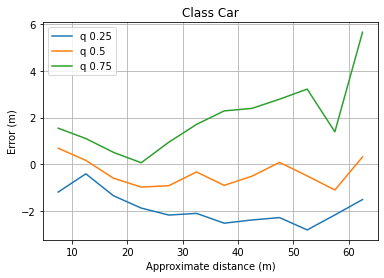

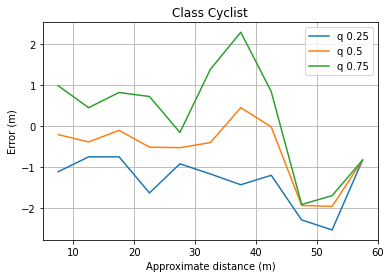

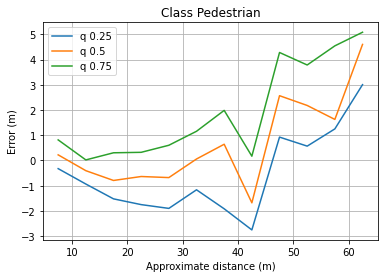

In [27]:
jump = 5
start = 5
end = 65
# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_val[(distance < df_val['distance_approx']) & \
                                     (df_val['distance_approx'] < distance+jump) & \
                                     (df_val['type'] == class_name)].apply(lambda row: row['distance']-row['distance_approx'], axis=1).quantile(q=[0.25,0.5,0.75])
        MDistanceE_distances.append(MDistanceE_distance)
    q_0_25 = list(map(lambda x: x.get(0.25), MDistanceE_distances))
    q_0_5 = list(map(lambda x: x.get(0.5), MDistanceE_distances))
    q_0_75 = list(map(lambda x: x.get(0.75), MDistanceE_distances))

    # Create plot
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_25)
    plt.plot(x, q_0_5)
    plt.plot(x, q_0_75)
    plt.legend(['q 0.25', 'q 0.5', 'q 0.75'])
    plt.title("Class %s" % class_name)
    plt.xlabel('Approximate distance (m)')
    plt.ylabel('Error (m)')
    plt.grid()
    plt.show()

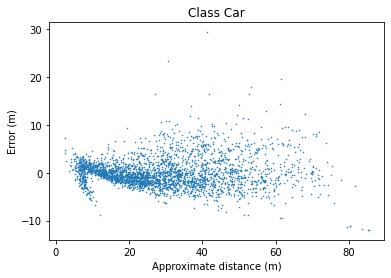

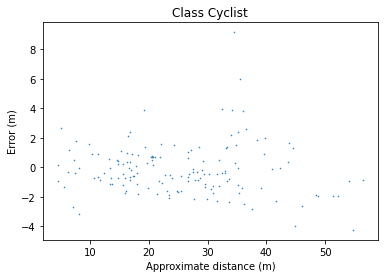

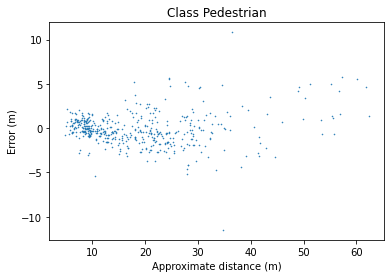

In [28]:
for class_name in ["Car","Cyclist","Pedestrian"]:
    df_val_class = df_val[df_val['type'] == class_name]

    Y = df_val_class['error_distance_approx'].values
    X = df_val_class['distance_approx'].values

    plt.title("Class %s" % class_name)
    plt.xlabel('Approximate distance (m)')
    plt.ylabel('Error (m)')

    plt.scatter(X, Y, s=0.3)
    plt.show()

## Evaluate in the validation dataset with KITTI difficulties.

In [29]:
def define_difficulty(row):
    height = row['bottom'] - row['top']
    occlusion = row['occluded']
    truncation = row['truncated']
    # Easy
    if(height >= 40 and occlusion == 0 and truncation <= 0.15):
        return 0
    elif(height >= 25 and occlusion <= 1 and truncation <= 0.3):
        return 1
    elif(height >= 25 and occlusion <= 2 and truncation <= 0.5):
        return 2
    else:
        return 3

In [30]:
df_val['difficulty'] = df_val.apply(lambda row: define_difficulty(row), axis=1)

In [32]:
df_val

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,...,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_approx,error_distance_approx,difficulty
0,5984,0,Car,0.00,1.0,3.10,431.50,171.26,514.83,204.10,...,2.91,35.233649,32.84,83.33,-0.19,False,False,37.223531,-1.989883,1
1,5984,1,Pedestrian,0.00,1.0,2.84,759.60,163.84,772.27,193.28,...,3.05,47.268786,29.44,12.67,0.21,False,False,43.724626,3.544160,1
2,5984,2,Car,0.00,0.0,1.22,699.42,157.64,744.58,190.94,...,1.37,50.845835,33.30,45.16,0.15,False,False,36.788248,14.057587,1
3,5984,3,Car,0.00,1.0,-2.01,729.47,164.21,774.61,189.74,...,-1.82,52.712075,25.53,45.14,0.19,False,False,46.111278,6.600798,1
4,5984,4,Car,0.00,0.0,-2.05,767.91,164.74,823.24,187.41,...,-1.80,53.584055,22.67,55.33,0.25,False,False,51.081492,2.502564,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3466,6731,3,Car,0.00,1.0,-1.76,285.26,204.19,379.79,277.17,...,-2.13,20.646545,72.98,94.53,-0.37,False,False,18.733749,1.912796,1
3467,6731,4,Car,0.00,1.0,1.68,19.76,205.74,103.40,276.05,...,1.04,28.752035,70.31,83.64,-0.64,False,False,19.369834,9.382201,1
3468,6731,5,Car,0.64,3.0,1.68,0.00,223.85,52.39,320.28,...,0.99,17.799868,96.43,52.39,-0.69,True,False,16.235017,1.564851,3
3469,6731,6,Car,0.00,2.0,-1.70,235.01,212.29,293.06,253.39,...,-2.14,32.968362,41.10,58.05,-0.44,False,False,30.794342,2.174020,2


In [34]:
difficulties = [0, 1, 2]                       
classes = ["Car","Cyclist","Pedestrian"]
text_difficulties = ["Easy", "Moderate", "Hard"]

def mse(frame):
    df_frame = df_val[df_val['frame'] == frame]
    bbs_distance_gt = df_frame['distance'].tolist()
    bbs_distance_approx = df_frame['distance_approx'].tolist()
    mse_value = mean_squared_error(bbs_distance_gt, bbs_distance_approx)
    
    return mse_value

print("################################", end="\n\n")

# Iterate over difficulties
for difficulty, text_difficulty in zip(difficulties, text_difficulties):
    # Iterate over classes
    for class_name in classes:                  
        df_difficulty = df_val[(df_val['difficulty'] <= difficulty) & (df_val['type'] == class_name)]
        mse_by_frame = df_difficulty['frame'].unique()
        start_time = time.time()
        mse_by_frame = list(map(mse, mse_by_frame))

        mse_by_frame_without_none = list(filter(partial(is_not, None), mse_by_frame))

        mean_mse = statistics.mean(mse_by_frame_without_none)
        print("--- %s seconds to calculate MSE, %s difficulty, %s class  ---" % (time.time() - start_time, text_difficulty, class_name))

        print("\nMean of all MSE by frame, %s difficulty, %s class = %s\n" % (text_difficulty, class_name, mean_mse))
        
    print("################################", end="\n\n")

################################

--- 0.24528264999389648 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 8.724546130171596

--- 0.02718663215637207 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 4.64307423863859

--- 0.06971120834350586 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 3.822423383669413

################################

--- 0.3431711196899414 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 9.115675391726825

--- 0.04277753829956055 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 5.902423682441222

--- 0.08919334411621094 seconds to calculate MSE, Moderate difficulty, Pedestrian class  ---

Mean of a